In [1]:
suppressPackageStartupMessages(suppressWarnings(library(ggplot2))) # plotting
suppressPackageStartupMessages(suppressWarnings(library(dplyr))) # data manipulation
suppressPackageStartupMessages(suppressWarnings(library(argparser))) # command line arguments
source("../../../figures/utils/figure_themes.r")


In [2]:
cell_type <- "PBMC"
model_name <- "MultiClass_MLP"


In [3]:
# set file path for importing the data
training_metrics_file <- file.path(paste0(
    "../../results/Multi_Class/",model_name,"/",cell_type,"/training_metrics.parquet"
))
confusion_matrix_file <- file.path(paste0(
    "../../results/Multi_Class/",model_name,"/",cell_type,"/confusion_matrices.parquet"
))

# set output file path for graphs
f1_plot_path <- file.path(paste0(
    "../../figures/Multi_Class/",model_name,"/",cell_type,"/f1_score.png"
))

confusion_matrix_plot_path <- file.path(paste0(
    "../../figures/Multi_Class/",model_name,"/",cell_type,"/confusion_matrix.png"
))
# set the path to the results
pr_curves_path <- file.path(paste0(
        "../../results/Multi_Class/",model_name,"/",cell_type,"/PR_curves.parquet"
))


# read in the data
training_metrics <- arrow::read_parquet(training_metrics_file)
confusion_matrix <- arrow::read_parquet(confusion_matrix_file)
PR_curves <- arrow::read_parquet(pr_curves_path)

In [4]:

support <- training_metrics[training_metrics$metric == "support",]
# get apoptosis, healthy, and pyroptosis support rows in one df
support <- support[support$label %in% c("apoptosis", "healthy", "pyroptosis"),]


In [5]:
# get the rows that contain the F1 scores
f1_scores <- training_metrics[training_metrics$metric == "f1-score",]
# remove the rows that contain the macro and weighted averages
f1_scores <- f1_scores[!grepl("macro avg", f1_scores$label),]
f1_scores <- f1_scores[!grepl("weighted avg", f1_scores$label),]
# muatate the label column for multiple cases
f1_scores$label <- gsub("healthy", "Control", f1_scores$label)
f1_scores$label <- gsub("apoptosis", "Apoptosis", f1_scores$label)
f1_scores$label <- gsub("pyroptosis", "Pyroptosis", f1_scores$label)
# mutate the data type column
f1_scores$group <- gsub("train", "Training", f1_scores$group)
f1_scores$group <- gsub("test", "Testing", f1_scores$group)
f1_scores$group <- gsub("validation", "Validation", f1_scores$group)
f1_scores$group <- gsub("treatment_holdout", "Treatment Holdout", f1_scores$group)
f1_scores$group <- gsub("holdout", "Holdout", f1_scores$group)
# factorize the group column
f1_scores$group <- factor(f1_scores$group, levels = c(
    "Training", "Validation", "Testing","Treatment Holdout", "Holdout"
))
# mutate the shuffled_data column
f1_scores$shuffled_data <- gsub("TRUE", "Shuffled", f1_scores$shuffled_data)
f1_scores$shuffled_data <- gsub("FALSE", "Not Shuffled", f1_scores$shuffled_data)
# cbind the support column to the f1_scores df
f1_scores <- cbind(f1_scores, support$value)
# rename the support column
colnames(f1_scores)[colnames(f1_scores) == "support$value"] <- "support"
# dived the support by 10,000 to get the number of cells
f1_scores$support <- f1_scores$support / 10000
# round the support column to 2 decimal places
f1_scores$support <- round(f1_scores$support, 2)


In [6]:
# make the label a factor so that the order is preserved
f1_scores$label <- factor(
    f1_scores$label, levels = c(
        "Control", "Apoptosis", "Pyroptosis"
        )
    )


F1 score  
### $F1 Score = 2 * \frac{precision * recall}{precision + recall}$
### $Precision = \frac{TP}{TP + FP}$
### $Recall = \frac{TP}{TP + FN}$
### $F1 Score = \frac{2 * TP}{2 * TP + FP + FN}$

In [7]:
head(f1_scores, 1)


,label,metric,value,group,shuffled_data,support
,<fct>,<chr>,<dbl>,<fct>,<chr>,<dbl>
1,Apoptosis,f1-score,0,Training,Shuffled,9.59


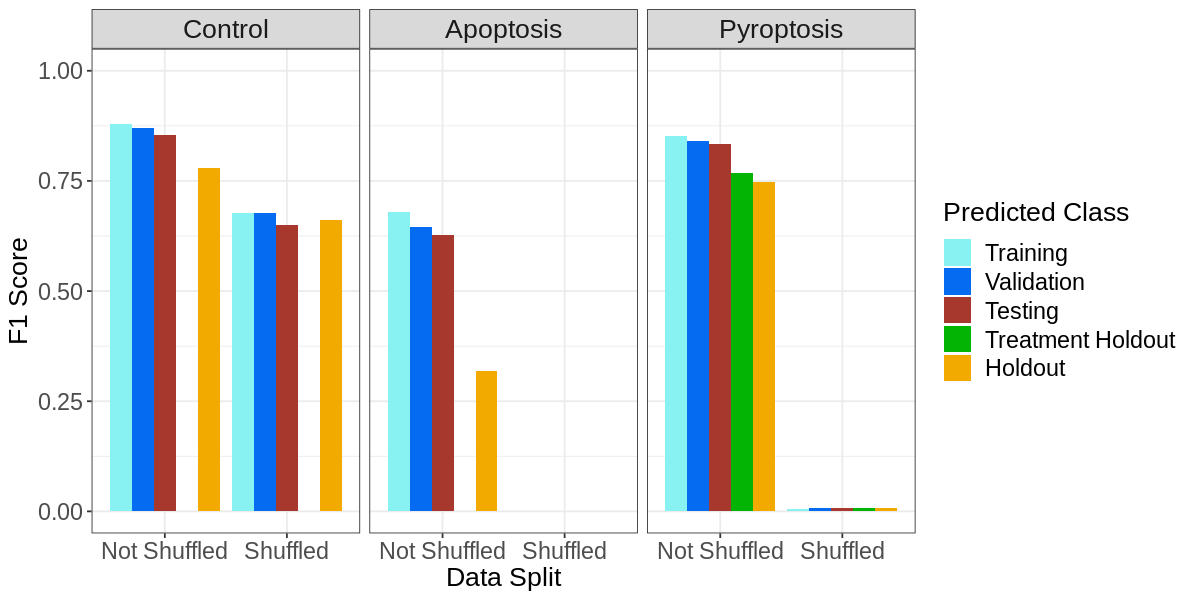

In [8]:
# set plot size
width <- 10
height <- 5
options(repr.plot.width = width, repr.plot.height = height)
# bar plot of the F1 scores
f1_score_plot <- (
    ggplot(f1_scores, aes(x = shuffled_data, y = value, fill = group))
    + geom_bar(stat = "identity", position = "dodge")

    + ylim(0, 1)
    + facet_wrap(~label)
    + ylab("F1 Score")
    + xlab("Data Split")
    # change the legend title
    + labs(fill = "Predicted Class")
    # change the colours
    + scale_fill_manual(values = c(
        "Training" = "#88F2F2",
        "Validation" = "#056CF2",
        "Testing" = "#A6382E",
        "Treatment Holdout" = "#04B404",
        "Holdout" = "#F2A900"
    ))
    + figure_theme_wide

)
ggsave(f1_plot_path, f1_score_plot, width = width, height = height, dpi = 600)
f1_score_plot


#### Confusion Matrix data plot

In [9]:
confusion_matrix

True_Label,Predicted_Label,Count,data_split,Recall,shuffled_data
<chr>,<chr>,<int>,<chr>,<dbl>,<lgl>
apoptosis,healthy,0,testing,0.000000000,TRUE
healthy,healthy,901882,testing,0.998088775,TRUE
pyroptosis,healthy,1727,testing,0.001911225,TRUE
apoptosis,apoptosis,0,testing,0.000000000,TRUE
healthy,apoptosis,119533,testing,0.996847662,TRUE
pyroptosis,apoptosis,378,testing,0.003152338,TRUE
apoptosis,pyroptosis,0,testing,0.000000000,TRUE
healthy,pyroptosis,850601,testing,0.996126051,TRUE
pyroptosis,pyroptosis,3308,testing,0.003873949,TRUE


In [10]:
# round the Recall vlaues to 2 decimal places
confusion_matrix$Recall <- round(confusion_matrix$Recall, 2)
# mutate the label column for multiple cases
confusion_matrix$True_Label <- gsub("healthy", "Control", confusion_matrix$True_Label)
confusion_matrix$True_Label <- gsub("apoptosis", "Apoptosis", confusion_matrix$True_Label)
confusion_matrix$True_Label <- gsub("pyroptosis", "Pyroptosis", confusion_matrix$True_Label)
confusion_matrix$Predicted_Label <- gsub("healthy", "Control", confusion_matrix$Predicted_Label)
confusion_matrix$Predicted_Label <- gsub("apoptosis", "Apoptosis", confusion_matrix$Predicted_Label)
confusion_matrix$Predicted_Label <- gsub("pyroptosis", "Pyroptosis", confusion_matrix$Predicted_Label)

# make the True Label and Predicted Label columns factors
confusion_matrix$True_Label <- factor(
    confusion_matrix$True_Label, levels = c(
        "Control", "Apoptosis", "Pyroptosis"
        )
    )
confusion_matrix$Predicted_Label <- factor(
    confusion_matrix$Predicted_Label, levels = c(
       "Pyroptosis", "Apoptosis", "Control"
        )
    )
    

# mutate the shuffled_data column
confusion_matrix$shuffled_data <- gsub("TRUE", "Shuffled", confusion_matrix$shuffled_data)
confusion_matrix$shuffled_data <- gsub("FALSE", "Not Shuffled", confusion_matrix$shuffled_data)
# mutate the data type column
confusion_matrix$data_split <- gsub("testing", "Testing", confusion_matrix$data_split)
confusion_matrix$data_split <- gsub("treatment_holdout", "Treatment Holdout", confusion_matrix$data_split)
confusion_matrix$data_split <- gsub("holdout", "Hold Out Wells", confusion_matrix$data_split)
# make the data split column a factor
confusion_matrix$data_split <- factor(confusion_matrix$data_split, levels = c(
    "Testing", "Hold Out Wells","Treatment Holdout"
))


In [11]:
# split the confusion matrix into testing/holdout and treatment holdout
confusion_matrix_testing <- confusion_matrix[confusion_matrix$data_split == "Testing",]
confusion_matrix_holdout <- confusion_matrix[confusion_matrix$data_split == "Hold Out Wells",]
confusion_matrix_treatment_holdout <- confusion_matrix[confusion_matrix$data_split == "Treatment Holdout",]

# combine the testing and holdout dataframes
confusion_matrix_testing_holdout <- rbind(confusion_matrix_testing, confusion_matrix_holdout)


#### Plot the confusion matrix of test data and holdout data

In [12]:
confusion_matrix_testing_holdout

True_Label,Predicted_Label,Count,data_split,Recall,shuffled_data
<fct>,<fct>,<int>,<fct>,<dbl>,<chr>
Apoptosis,Control,0,Testing,0.00,Shuffled
Control,Control,901882,Testing,1.00,Shuffled
Pyroptosis,Control,1727,Testing,0.00,Shuffled
Apoptosis,Apoptosis,0,Testing,0.00,Shuffled
Control,Apoptosis,119533,Testing,1.00,Shuffled
Pyroptosis,Apoptosis,378,Testing,0.00,Shuffled
Apoptosis,Pyroptosis,0,Testing,0.00,Shuffled
Control,Pyroptosis,850601,Testing,1.00,Shuffled
Pyroptosis,Pyroptosis,3308,Testing,0.00,Shuffled


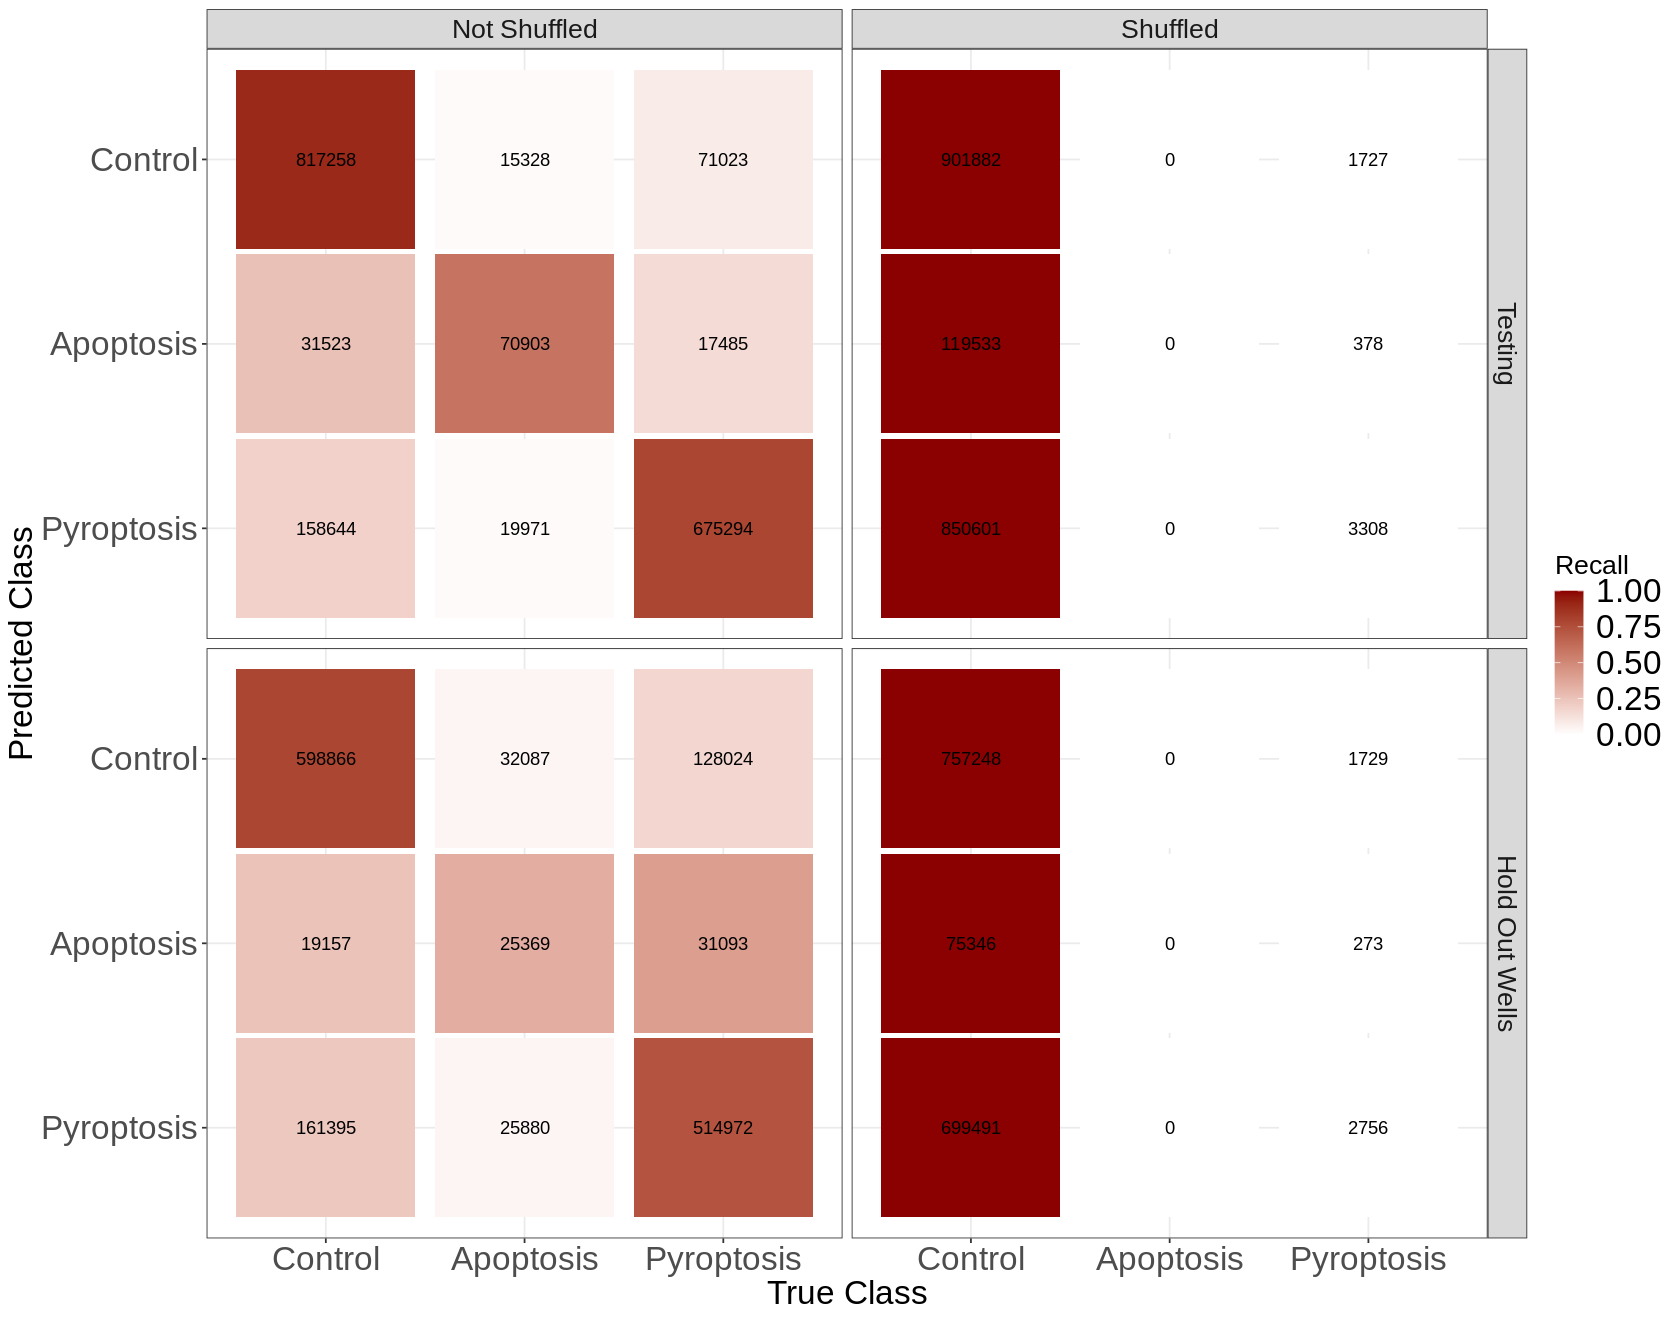

In [13]:
# plot dimensions
width <- 14
height <- 11
options(repr.plot.width = width, repr.plot.height = height)
# plot a confusion matrix
confusion_matrix_plot <- (
    ggplot((confusion_matrix_testing_holdout), aes(x = True_Label, y = Predicted_Label))
    + facet_grid(data_split~shuffled_data)
    + geom_point(aes(color = Recall), size = 50, shape = 15)
    + geom_text(aes(label = Count))
    + scale_color_gradient("Recall", low = "white", high = "dark red",limits = c(0, 1))
    + theme_bw()
    + ylab("Predicted Class")
    + xlab("True Class")
    + figure_theme


)
ggsave(confusion_matrix_plot_path, confusion_matrix_plot, width = width, height = height, dpi = 600)
confusion_matrix_plot


In [14]:
# read in the data
treatment_holdout_single_cell_predictions_path <- file.path(
    paste0(
        "../../results/Multi_Class/",model_name,"/",cell_type,"/treatment_holdout_single_cell_predictions.parquet"
    )
)
# read in the data from the parquet file
treatment_holdout_single_cell_predictions <- arrow::read_parquet(
    treatment_holdout_single_cell_predictions_path
)
head(treatment_holdout_single_cell_predictions)

true_label,predicted_label,Metadata_cell_type,Metadata_Well,Metadata_number_of_singlecells,Metadata_incubation inducer (h),Metadata_inhibitor,Metadata_inhibitor_concentration,Metadata_inhibitor_concentration_unit,Metadata_inducer1,⋯,Metadata_Plate,Metadata_Cells_Number_Object_Number,Metadata_Cytoplasm_Parent_Cells,Metadata_Cytoplasm_Parent_Nuclei,Metadata_Nuclei_Number_Object_Number,Metadata_Treatment,Metadata_Dose,labels,data_split,shuffle
<int>,<int>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<lgl>
2,1,PBMC,D03,34398,6,DMSO,0.025,%,LPS,⋯,*70117_20230210MM1_Gasdermin514_CP_BC430856,6,6,7,7,LPS,1.000_µg_per_ml,pyroptosis,treatment_holdout,TRUE
2,1,PBMC,D03,34398,6,DMSO,0.025,%,LPS,⋯,*70117_20230210MM1_Gasdermin514_CP_BC430856,7,7,8,8,LPS,1.000_µg_per_ml,pyroptosis,treatment_holdout,TRUE
2,1,PBMC,D03,34398,6,DMSO,0.025,%,LPS,⋯,*70117_20230210MM1_Gasdermin514_CP_BC430856,11,11,13,13,LPS,1.000_µg_per_ml,pyroptosis,treatment_holdout,TRUE
2,1,PBMC,D03,34398,6,DMSO,0.025,%,LPS,⋯,*70117_20230210MM1_Gasdermin514_CP_BC430856,12,12,14,14,LPS,1.000_µg_per_ml,pyroptosis,treatment_holdout,TRUE
2,1,PBMC,D03,34398,6,DMSO,0.025,%,LPS,⋯,*70117_20230210MM1_Gasdermin514_CP_BC430856,15,15,17,17,LPS,1.000_µg_per_ml,pyroptosis,treatment_holdout,TRUE
2,1,PBMC,D03,34398,6,DMSO,0.025,%,LPS,⋯,*70117_20230210MM1_Gasdermin514_CP_BC430856,16,16,18,18,LPS,1.000_µg_per_ml,pyroptosis,treatment_holdout,TRUE


In [15]:
unique(treatment_holdout_single_cell_predictions$shuffle)
# split the data into shuffled and not shuffled
treatment_holdout_single_cell_predictions_shuffled <- treatment_holdout_single_cell_predictions[
    treatment_holdout_single_cell_predictions$shuffle == "TRUE",]
treatment_holdout_single_cell_predictions_not_shuffled <- treatment_holdout_single_cell_predictions[
    treatment_holdout_single_cell_predictions$shuffle == "FALSE",]

[1]  TRUE FALSE

In [16]:
# calculate the recall of class 2 (pyroptosis)
recall_shuffle <- treatment_holdout_single_cell_predictions_shuffled %>% 
    filter(true_label == 2 & predicted_label == 2) %>% 
    nrow() / treatment_holdout_single_cell_predictions_shuffled %>% 
    filter(true_label == 2) %>% 
    nrow()
# calculate the precision of class 2 (pyroptosis)
precision_shuffle <- treatment_holdout_single_cell_predictions_shuffled %>% 
    filter(true_label == 2 & predicted_label == 2) %>% 
    nrow() / treatment_holdout_single_cell_predictions_shuffled %>% 
    filter(predicted_label == 2) %>% 
    nrow()
# calculate the F1 score which is the harmonic mean of precision and recall
f1_score_shuffle <- 2 * (precision_shuffle * recall_shuffle) / (precision_shuffle + recall_shuffle)


# calculate the recall of class 2 (pyroptosis)
recall <- treatment_holdout_single_cell_predictions_not_shuffled %>% 
    filter(true_label == 2 & predicted_label == 2) %>% 
    nrow() / treatment_holdout_single_cell_predictions_not_shuffled %>% 
    filter(true_label == 2) %>% 
    nrow()
# calculate the precision of class 2 (pyroptosis)
precision <- treatment_holdout_single_cell_predictions_not_shuffled %>% 
    filter(true_label == 2 & predicted_label == 2) %>% 
    nrow() / treatment_holdout_single_cell_predictions_not_shuffled %>% 
    filter(predicted_label == 2) %>% 
    nrow()
# calculate the F1 score which is the harmonic mean of precision and recall
f1_score <- 2 * (precision * recall) / (precision + recall)

print(paste("F1 score for shuffled data:", f1_score_shuffle))
print(paste("F1 score for not shuffled data:", f1_score))


[1] "F1 score for shuffled data: 0.00679589964879931"
[1] "F1 score for not shuffled data: 0.767790724320894"


## PR Curves

In [17]:
# replace strings in pr_curves
PR_curves$label <- gsub("apoptosis", "Apoptosis", PR_curves$label)
PR_curves$label <- gsub("healthy", "Control", PR_curves$label)
PR_curves$label <- gsub("pyroptosis", "Pyroptosis", PR_curves$label)

PR_curves$data_split <- gsub("train", "Training", PR_curves$data_split)
PR_curves$data_split <- gsub("testing", "Testing", PR_curves$data_split)
PR_curves$data_split <- gsub("validation", "Validation", PR_curves$data_split)
PR_curves$data_split <- gsub("treatment_holdout", "Treatment Holdout", PR_curves$data_split)
PR_curves$data_split <- gsub("holdout", "Holdout", PR_curves$data_split)

# factorize the data_split column
PR_curves$data_split <- factor(PR_curves$data_split, levels = c(
    "Training", "Validation", "Testing","Treatment Holdout", "Holdout"
))

unique(PR_curves$label)
unique(PR_curves$data_split)

# replace strings in pr_curves shuffle
PR_curves$shuffle <- gsub("TRUE", "Shuffled", PR_curves$shuffle)
PR_curves$shuffle <- gsub("FALSE", "Not Shuffled", PR_curves$shuffle)

# factorize the shuffled_data column
PR_curves$shuffle <- factor(PR_curves$shuffle, levels = c(
    "Not Shuffled", "Shuffled"
))



[1] "Apoptosis"  "Control"    "Pyroptosis"

[1] Training          Validation        Testing           Treatment Holdout
[5] Holdout          
Levels: Training Validation Testing Treatment Holdout Holdout

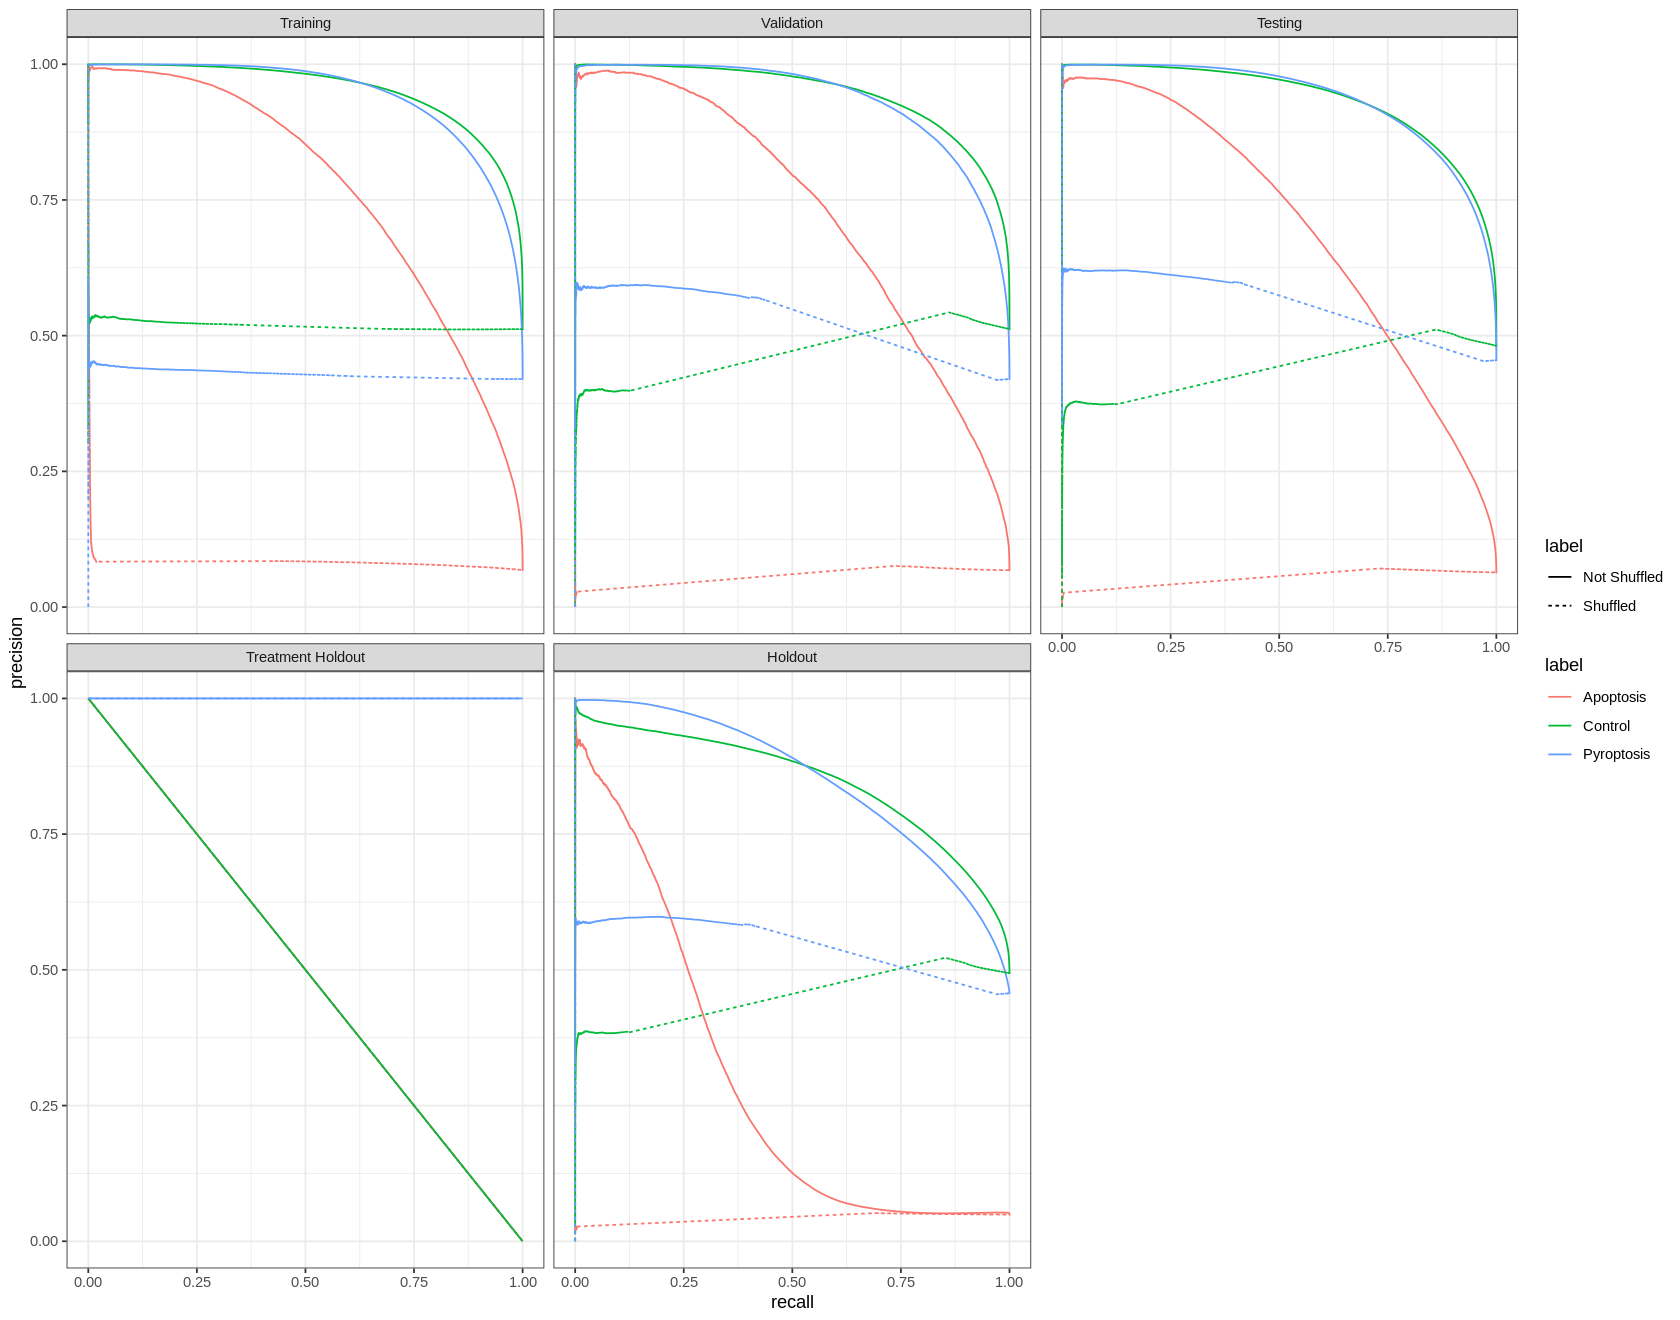

In [18]:
# make a line plot that has the shuffled and not shuffled lines
# with shuffled lines dashed and not shuffled lines solid
# color by label 
pr_plot <- (
    ggplot(PR_curves, aes(x = recall, y = precision, color = label, linetype = label))
    + geom_line(aes(linetype = shuffle))
    # + scale_linetype_manual(values = c("solid", "dashed"))
    + facet_wrap(~data_split)
    + theme_bw()
)
pr_plot


In [19]:
# read in the single cell predictions
treatment_holdout_predictions_path <- file.path(
    paste0(
        "../../results/Multi_Class/",model_name,"/",cell_type,"/treatment_holdout_single_cell_predictions.parquet"
    )
)
# read in the data from the parquet file
treatment_holdout_predictions <- arrow::read_parquet(
    treatment_holdout_predictions_path
)
head(treatment_holdout_predictions)

true_label,predicted_label,Metadata_cell_type,Metadata_Well,Metadata_number_of_singlecells,Metadata_incubation inducer (h),Metadata_inhibitor,Metadata_inhibitor_concentration,Metadata_inhibitor_concentration_unit,Metadata_inducer1,⋯,Metadata_Plate,Metadata_Cells_Number_Object_Number,Metadata_Cytoplasm_Parent_Cells,Metadata_Cytoplasm_Parent_Nuclei,Metadata_Nuclei_Number_Object_Number,Metadata_Treatment,Metadata_Dose,labels,data_split,shuffle
<int>,<int>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<lgl>
2,1,PBMC,D03,34398,6,DMSO,0.025,%,LPS,⋯,*70117_20230210MM1_Gasdermin514_CP_BC430856,6,6,7,7,LPS,1.000_µg_per_ml,pyroptosis,treatment_holdout,TRUE
2,1,PBMC,D03,34398,6,DMSO,0.025,%,LPS,⋯,*70117_20230210MM1_Gasdermin514_CP_BC430856,7,7,8,8,LPS,1.000_µg_per_ml,pyroptosis,treatment_holdout,TRUE
2,1,PBMC,D03,34398,6,DMSO,0.025,%,LPS,⋯,*70117_20230210MM1_Gasdermin514_CP_BC430856,11,11,13,13,LPS,1.000_µg_per_ml,pyroptosis,treatment_holdout,TRUE
2,1,PBMC,D03,34398,6,DMSO,0.025,%,LPS,⋯,*70117_20230210MM1_Gasdermin514_CP_BC430856,12,12,14,14,LPS,1.000_µg_per_ml,pyroptosis,treatment_holdout,TRUE
2,1,PBMC,D03,34398,6,DMSO,0.025,%,LPS,⋯,*70117_20230210MM1_Gasdermin514_CP_BC430856,15,15,17,17,LPS,1.000_µg_per_ml,pyroptosis,treatment_holdout,TRUE
2,1,PBMC,D03,34398,6,DMSO,0.025,%,LPS,⋯,*70117_20230210MM1_Gasdermin514_CP_BC430856,16,16,18,18,LPS,1.000_µg_per_ml,pyroptosis,treatment_holdout,TRUE
